# Let's Train Tiny MoE





### Configure the machine and install packages


In [3]:
from typing import Literal

import os

os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
#os.environ["TF_GPU_ALLOCATOR"] = 'cuda_malloc_async'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on darwin


In [4]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [5]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh


mesh = jax.sharding.Mesh(jax.devices(), ["devices"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.6.2
Flax version 0.10.7
Available devices: 8


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_1663/3250393803.py:26: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


248 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the model and perform a sanity check

In [6]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

Run: run_20250729_ffwghl


In [7]:
if platform == "cuda":
  output_dir = Path("/workspace/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup
print(f"{output_dir=}")

output_dir=PosixPath('/Users/vikram/dev/jaxpt/alpha_training_runs')


In [8]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import Tiny_MoE_Config, Tiny_MoE
from jaxpt.utils import count_params, create_sharded_model

import tiktoken
from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = Tiny_MoE_Config(dtype=jnp.bfloat16, \
                     #vocab_size=49152,
                     n_layer=30,
                     block_size=2048,
                     n_head=9,
                     n_kv_head=3,
                     n_embed=576,
                     n_mlp_hidden=1536,
                     sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)

with mesh:
    m = create_sharded_model(Tiny_MoE, config, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250716_htlpzj", 381469, rngs)
    #m = load_checkpoint_from_gcloud(Mobile_LLM, config, output_dir, "alpha_training_runs", "run_20250521_pakugd", "9000", rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)
    moe_params = count_params(m, "experts")
    print(f"Parameter Count: {total_params:,}")
    print(f"MOE Parameter Count: {moe_params:,}")
    replicated_params = total_params - moe_params
    print(f"Replicated Parameter Count: {replicated_params:,}")
    active_params = replicated_params + ( 2 / 8 ) * moe_params
    print(f"Active Parameter Count: {active_params:,}")
    fraction_of_active_params = active_params / total_params
    print(f"% Active Parameters: {fraction_of_active_params*100:0.2f} %")
    nnx.display(state)

    #enc = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    #completions = generate_completions(m, enc=enc, num_completions=8,
    #                                max_length=21,
    #                                prefix="Ducks quack, donkeys bray, cats mew, horses")
    #for completion in completions:
    #    print(completion)

Parameter Count: 414,377,280
MOE Parameter Count: 318,942,720
Replicated Parameter Count: 95,434,560
Active Parameter Count: 175,170,240.0
% Active Parameters: 42.27 %


In [9]:
m.h[0].moe.experts.w_c_fc.device

NamedSharding(mesh=Mesh('devices': 8, axis_types=(Auto,)), spec=PartitionSpec('devices',), memory_kind=unpinned_host)

### Configure Training Run

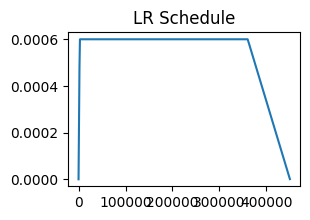

weight decay param count: 414,342,144
tokens/batch: 524,288
block size: 2048
batch size: 256
no. gradient accumulation steps: 1
effective batch size: 256
effective batch size per device:  32
max steps: 450,134


In [10]:
import dataclasses

import optax


############################
# Nvidia H200 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens: int = int(236e9)
  num_tokens_per_batch: int = 2**19  # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 32 * num_devices
  T: int = 2048
  max_steps: int = int(num_tokens // num_tokens_per_batch)
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 2500
  print_interval: int = 100
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient

trconf = TrainerConfig()

##############
# CPU Config #
##############

'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
    #optax.adafactor(trapezoidal_schedule, weight_decay_rate=0.01, weight_decay_mask=weight_decay_mask),
    #optax.adam(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)

print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [12]:
import os

from jaxpt.dataloaders import BlendedCloudDataLoader, CloudDataLoader

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

'''
train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")
'''


train_dl = BlendedCloudDataLoader(
    device_rank=1,
    block_size=trconf.T,
    batch_size=trconf.mB,
    bucket_names=["jaxpt_datasets", "jaxpt_datasets", "jaxpt_datasets"],
    bucket_prefixes=["smollm-corpus/processed/fineweb-edu-dedup",
    "smollm-corpus/processed/python-edu",
    "smollm-corpus/processed/cosmopedia-v2"],
    proportions=[85, 1, 12],
    label="train"
)

Initializing blended dataset with batch sizes: [222   3  31]
CloudDataLoader initialized:
------------------------
label:          train
shards:         1,936
shard size:     100,000,000
batch size:     222
block size:     2048
device rank:    1
start shard:    0
start pos:      0
------------------------
CloudDataLoader initialized:
------------------------
label:          train
shards:         40
shard size:     100,000,000
batch size:     3
block size:     2048
device rank:    1
start shard:    0
start pos:      0
------------------------
CloudDataLoader initialized:
------------------------
label:          train
shards:         279
shard size:     100,000,000
batch size:     31
block size:     2048
device rank:    1
start shard:    0
start pos:      0
------------------------


In [11]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0
start = False

Log directory: /workspace/alpha_training_runs/Tiny_MoE/logs


Received KeyboardInterrupt. Exiting..._loss: 15.0003 | time: 364.71ms | tokens processed: 2,988,965,888 | tok/sec: 1,437,565.51


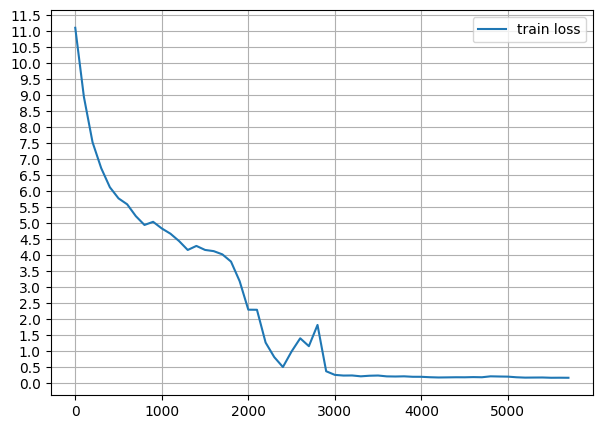

In [20]:
%matplotlib inline

import time

import optax

import matplotlib.pyplot as plt


#from jaxpt.train import moe_loss_fn, loss_fn

def moe_loss_fn(model, batch, targets):
    logits, aux_loss = model(batch, None)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    return loss.mean() + model.config.aux_loss_coeff * aux_loss, (aux_loss, logits)

@nnx.jit
def train_step(model, optimizer, batch, target):
    batch = batch.squeeze()
    target = target.squeeze()
    (loss, (aux_loss, logits)), grads = nnx.value_and_grad(moe_loss_fn, has_aux=True)(model, batch, target)
    optimizer.update(grads)
    return loss, aux_loss, logits

with mesh:
  data_sharding = NamedSharding(mesh, PartitionSpec("devices",))
  m.train(add_noise=True, aux_loss=True)
  try:
    while step < trconf.max_steps:
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), data_sharding)
      target = jax.device_put(target.squeeze(), data_sharding)
      avg_loss, aux_loss, logits = train_step(m, optimizer, batch, target)
      #avg_loss.block_until_ready()
      if step % trconf.print_interval == 0:
        if not start:
          start = time.time()
          iter_time = -1
          sub_step_time = -1
          tokens_per_sec = -1
        else:
          iter_time = (time.time() - start) / trconf.print_interval
          sub_step_time = iter_time / trconf.grad_accumulation_steps
          tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time

        tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T
        lr = trapezoidal_schedule(step)
        avg_loss = avg_loss.item()

        train_losses.append((step, avg_loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.4f} | "
              f"loss: {avg_loss:0.4f} | "
              f"aux_loss: {aux_loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
        start = time.time()
      if step % trconf.eval_interval == 0:
        save_checkpoint(m, output_dir, run_dirname, step)
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(7, 5))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.yticks(ticks=np.arange(0, 12, 0.5))
  plt.grid()
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()

In [ ]:
save_checkpoint(m, output_dir, run_dirname, step)

In [ ]:

enc = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-360M")

In [19]:
with mesh:
    m.eval(add_noise=False, aux_loss=False)
    completions = generate_completions(m, num_completions=8,
                                    max_length=21,
                                    temperature=0.01,
                                    prefix="The musical genius Beethoven was",
                                    key=jax.random.key(0))
    for completion in completions:
        print(completion)

The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of
The musical genius Beethoven was the first and the story of the musical genius.
The philosophy of


In [ ]:
print(batch[0, :50])
print(target[0, :50])
jnp.argmax(logits, axis=-1)[0, :50]

[18568    30  1069    28   281  1607    28   359  9075   411   260 12619
  3231  3992 22417  2509   429 24344  9677 15491    28  7162    30   198
  2068   260  4081    28  8700   608   100  5378  2071 10620 20953    28
  1683   351   253  6260 10269  5432   338   919   614  1978 10247   272
  2071  1268]
[   30  1069    28   281  1607    28   359  9075   411   260 12619  3231
  3992 22417  2509   429 24344  9677 15491    28  7162    30   198  2068
   260  4081    28  8700   608   100  5378  2071 10620 20953    28  1683
   351   253  6260 10269  5432   338   919   614  1978 10247   272  2071
  1268  1317]


Array([   28,  1069,  2422,   502,  1607,   359,   359,  1217,   429,
         260,  4921, 11525,  3992,   281,  2509,   429,  7162,    95,
          30,    30,   284,    30,   198,   788,   260,  4203,   282,
         260,   269,   100,  6476,   281,  4173, 20953,    28,   253,
         351,   253,  1165, 10393,    28,   338,  2978,   624,   260,
         272,   272,    28,  4173,   463], dtype=int32)